In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from paraspec.base import IR12SpeciationModel
from paraspec.fastscape_ext import FastscapeElevationTrait

%matplotlib inline

# Run the model in a static landscape

In [2]:
length = (250, 250)
spacing = (1, 1)

X, Y = np.meshgrid(*[np.arange(0, l+s, s)
                     for l, s in zip(length, spacing)])

r = np.random.RandomState(0)

environment = X * 10 + r.rand(*Y.shape)

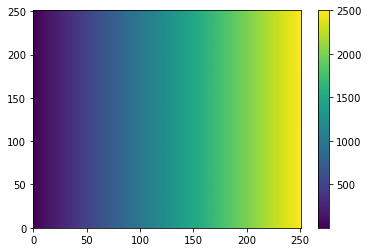

In [3]:
plt.pcolormesh(environment)
plt.colorbar();

# Initial parameters for speciation models

In [4]:
pop_size = 10
num_gen = 500
plot_at = np.linspace(0,num_gen-1,10).astype(int)
dt = 1e0

In [5]:
trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
trait_01_elev.initialize()

trait_02_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=-0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
trait_02_elev.initialize()



init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    'trait_2': trait_02_elev.init_trait_func
}

opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func,
    'trait_2': trait_02_elev.opt_trait_func
}

## Speciation model without trait-mediated competition

In [6]:
def mode1_run():
    model1 = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size, 
                                 nb_radius=50, car_cap=25,
                                 sigma_env_trait=0.2, sigma_mov=5, sigma_mut=0.05,
                                 mut_prob=1., random_seed=1234)
    print(model1)
    model1.initialize()
    dfs1 = []
    for step in range(num_gen):
        model1.evaluate_fitness(dt)
        dfs1.append(model1.to_dataframe())
        model1.update_individuals(dt)
    return pd.concat(dfs1)

In [7]:
%time df1 = mode1_run()
df1

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    distance_method: ward
    distance_value: 0.5
    nb_radius: 50
    car_cap: 25
    sigma_env_trait: 0.2
    sigma_mov: 5
    sigma_mut: 0.05
    mut_prob: 1.0

CPU times: user 28.8 s, sys: 169 ms, total: 28.9 s
Wall time: 28.8 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0,trait_1
0,0,0.0,0.0,244.174942,110.251531,1,0,0,0.006031,0.500000,0.500000
1,0,0.0,0.0,95.048934,152.467702,1,0,6,0.723356,0.500000,0.500000
2,0,0.0,0.0,230.811558,215.905324,1,0,0,0.017309,0.500000,0.500000
3,0,0.0,0.0,65.423106,215.939418,1,0,2,0.272955,0.500000,0.500000
4,0,0.0,0.0,79.774265,168.720328,1,0,3,0.482343,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
204,499,499.0,0.0,232.609148,47.459036,25491,25463,1,0.649715,0.733400,0.033177
205,499,499.0,0.0,239.885919,47.514046,25491,25463,1,0.396316,0.843115,0.318725
206,499,499.0,0.0,217.752641,26.806412,25491,25463,1,0.745197,0.947258,0.025541
207,499,499.0,0.0,216.354493,225.264334,25511,25450,1,0.677235,0.714450,0.272276


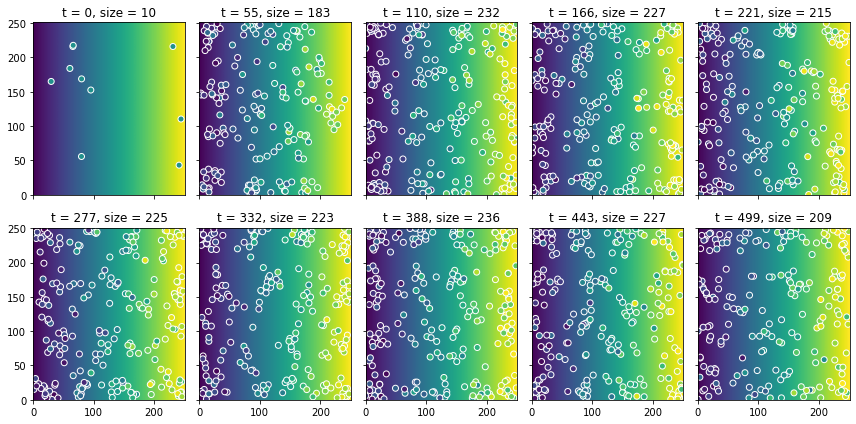

In [8]:
fig1, axes1 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes1.ravel(), plot_at):
    pop = df1.groupby('step').get_group(print_step)
    ax.pcolormesh(environment)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig1.tight_layout()

Text(0.5, 0, 'Time (generations)')

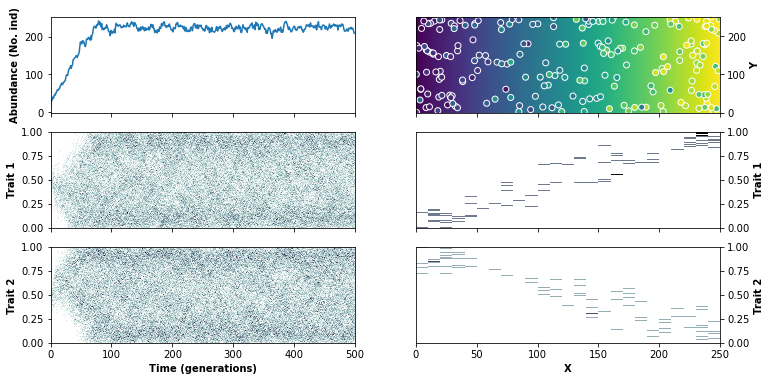

In [9]:
fig2, axs2 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
axs2[0,0].plot(df1.groupby('step').size())

axs2[0, 1].pcolormesh(environment)
axs2[0, 1].scatter(df1['x'].loc[df1['step']==max(df1['step'])], 
                   df1['y'].loc[df1['step']==max(df1['step'])], 
                   c=df1['trait_0'].loc[df1['step']==max(df1['step'])],
                   edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs2[1,1].hist2d(x=df1['x'].loc[df1['step']==max(df1['step'])], 
                                 y=df1['trait_0'].loc[df1['step']==max(df1['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs2[1,0].hist2d(x=df1['step'], y=df1['trait_0'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,1].hist2d(x=df1['x'].loc[df1['step']==max(df1['step'])], 
                                 y=df1['trait_1'].loc[df1['step']==max(df1['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df1['step'], y=df1['trait_1'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
axs2[0, 1].yaxis.set_label_position("right")
axs2[0, 1].yaxis.tick_right()
axs2[1, 1].yaxis.set_label_position("right")
axs2[1, 1].yaxis.tick_right()
axs2[2, 1].yaxis.set_label_position("right")
axs2[2, 1].yaxis.tick_right()
axs2[0, 1].set_ylabel('Y', weight='bold')
axs2[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
axs2[1, 1].set_ylabel('Trait 1', weight='bold')
axs2[1, 0].set_ylabel('Trait 1', weight='bold')
axs2[2, 1].set_ylabel('Trait 2', weight='bold')
axs2[2, 0].set_ylabel('Trait 2', weight='bold')
axs2[2, 1].set_xlabel('X', weight='bold')
axs2[2, 0].set_xlabel('Time (generations)', weight='bold')

## Speciation model with trait-mediated competition

In [10]:
from paraspec.base import DD03SpeciationModel

In [11]:
def model2_run():
    model2 = DD03SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size,
                                 birth_rate=1, movement_rate=5,  
                                 car_cap_max=250, sigma_env_trait=0.2, 
                                 mut_prob=1.0, sigma_mut=0.05, sigma_mov=5, 
                                 sigma_comp_trait=0.9, sigma_comp_dist=0.1, 
                                 random_seed=1234)
    
    print(model2)
    model2.initialize()
    dfs2 = []
    for step in range(num_gen):
        model2.evaluate_fitness(dt)
        dfs2.append(model2.to_dataframe())
        model2.update_individuals(dt)
    return pd.concat(dfs2)

In [12]:
%time df2 = model2_run()
df2

<DD03SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    distance_method: ward
    distance_value: 0.5
    birth_rate: 1
    movement_rate: 5
    car_cap_max: 250
    sigma_env_trait: 0.2
    mut_prob: 1.0
    sigma_mut: 0.05
    sigma_mov: 5
    sigma_comp_trait: 0.9
    sigma_comp_dist: 0.1

CPU times: user 14.6 s, sys: 71.3 ms, total: 14.7 s
Wall time: 14.7 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,events_i,death_i,trait_0,trait_1
0,0,0.0,0.0,244.174942,110.251531,1,0,2,B,0.721016,0.500000,0.500000
1,0,0.0,0.0,95.048934,152.467702,1,0,1,M,0.050568,0.500000,0.500000
2,0,0.0,0.0,230.811558,215.905324,1,0,1,M,0.271114,0.500000,0.500000
3,0,0.0,0.0,65.423106,215.939418,1,0,1,M,0.078637,0.500000,0.500000
4,0,0.0,0.0,79.774265,168.720328,1,0,2,B,0.062293,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
247,499,499.0,1.0,228.539836,150.942511,93558,93319,1,M,1.119186,0.795558,0.207765
248,499,499.0,1.0,239.130192,30.814036,93558,93319,1,M,1.154686,0.761631,0.206071
249,499,499.0,1.0,77.717349,131.651109,93552,93313,2,B,1.127756,0.358333,0.504576
250,499,499.0,1.0,123.564990,131.282268,93509,93362,1,M,1.092081,0.410913,0.514046


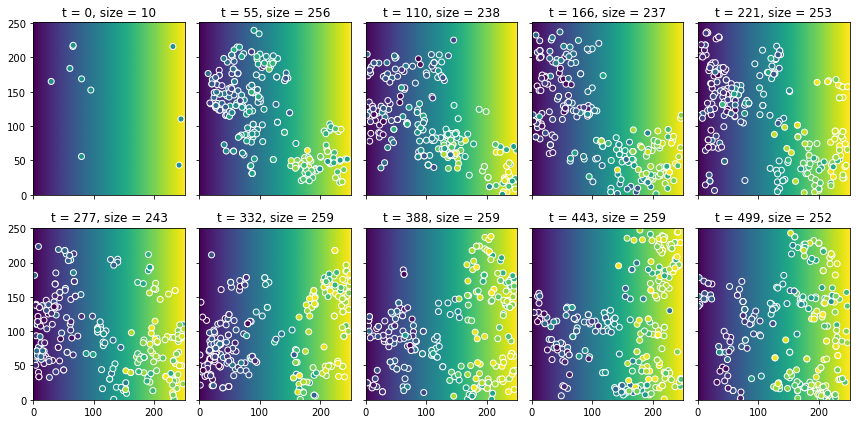

In [13]:
fig3, axes3 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes3.ravel(), plot_at):
    pop = df2.groupby('step').get_group(print_step)
    ax.pcolormesh(environment)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig3.tight_layout()

Text(0.5, 0, 'Time (generations)')

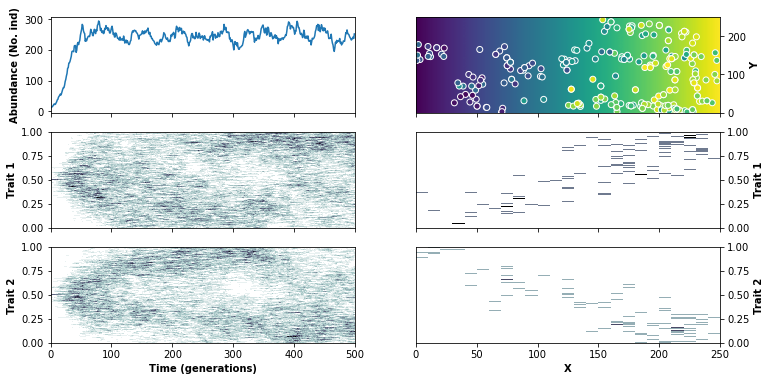

In [14]:
fig4, axs4 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
axs4[0,0].plot(df2.groupby('step').size())
axs4[0, 1].pcolormesh(environment)
axs4[0, 1].scatter(df2['x'].loc[df2['step']==max(df2['step'])], 
                      df2['y'].loc[df2['step']==max(df2['step'])], 
                      c=df2['trait_0'].loc[df2['step']==max(df2['step'])], 
                      edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs4[1,1].hist2d(x=df2['x'].loc[df2['step']==max(df2['step'])], 
                                 y=df2['trait_0'].loc[df2['step']==max(df2['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs4[1,0].hist2d(x=df2['step'], y=df2['trait_0'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
h,xedge,yedge,_=axs4[2,1].hist2d(x=df2['x'].loc[df2['step']==max(df2['step'])], 
                                 y=df2['trait_1'].loc[df2['step']==max(df2['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs4[2,0].hist2d(x=df2['step'], y=df2['trait_1'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
axs4[0, 1].yaxis.set_label_position("right")
axs4[0, 1].yaxis.tick_right()
axs4[1, 1].yaxis.set_label_position("right")
axs4[1, 1].yaxis.tick_right()
axs4[2, 1].yaxis.set_label_position("right")
axs4[2, 1].yaxis.tick_right()
axs4[0, 1].set_ylabel('Y', weight='bold')
axs4[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
axs4[1, 1].set_ylabel('Trait 1', weight='bold')
axs4[1, 0].set_ylabel('Trait 1', weight='bold')
axs4[2, 1].set_ylabel('Trait 2', weight='bold')
axs4[2, 0].set_ylabel('Trait 2', weight='bold')
axs4[2, 1].set_xlabel('X', weight='bold')
axs4[2, 0].set_xlabel('Time (generations)', weight='bold')

In [15]:
#%timeit mode1_run()

In [16]:
#%timeit model2_run()